In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from fastprogress import progress_bar
import numpy as np
import pandas as pd

import torch
from  torch import nn

In [3]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

In [5]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [6]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [7]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

In [8]:
# data.show_batch(3, figsize=(6,6))

In [9]:
learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=MSELossFlat()
)#.to_fp16()

In [11]:
learn.path = Path('..')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


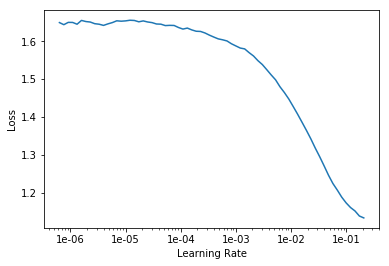

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.freeze_to(-1)
learn.fit_one_cycle(
    30, 
    slice(1e-2), 
    callbacks=[
        SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-1'),
        EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=3)
    ]
)

epoch,train_loss,valid_loss,time
0,1.042396,0.198158,01:11
1,0.604568,0.094170,01:10
2,0.315669,0.060653,01:11
3,0.202752,0.063023,01:11
4,0.169145,0.056395,01:11
5,0.142665,0.048790,01:11
6,0.105508,0.034817,01:11
7,0.084674,0.025406,01:11
8,0.064814,0.016685,01:11
9,0.073346,0.015950,01:11


Better model found at epoch 0 with valid_loss value: 0.19815798103809357.
Better model found at epoch 1 with valid_loss value: 0.09417025744915009.
Better model found at epoch 2 with valid_loss value: 0.060653455555438995.
Better model found at epoch 4 with valid_loss value: 0.05639549344778061.
Better model found at epoch 5 with valid_loss value: 0.048790331929922104.
Better model found at epoch 6 with valid_loss value: 0.03481731191277504.
Better model found at epoch 7 with valid_loss value: 0.025406161323189735.
Better model found at epoch 8 with valid_loss value: 0.016685357317328453.
Better model found at epoch 9 with valid_loss value: 0.015950292348861694.
Better model found at epoch 10 with valid_loss value: 0.012695029377937317.
Better model found at epoch 11 with valid_loss value: 0.012000830844044685.
Epoch 12: early stopping


In [12]:
learn = learn.load('fastai_model')
# learn = learn.to_fp32()
# learn.save('fastai_model')

In [13]:
# learn.show_results(rows=10)

In [14]:
%%writefile pet_regression.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['fastai'])
@artifacts([FastaiModelArtifact('pet_regressor')])
class PetRegression(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_regressor.predict(image)
        return str(result)

Overwriting pet_regression.py


In [15]:
# 1) import the custom BentoService defined above
from pet_regression import PetRegression

# 2) `pack` it with required artifacts
service = PetRegression.pack(pet_regressor=learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2019-11-17 16:11:11,323] INFO - Successfully saved Bento 'PetRegression:20191117161038_E7781A' to path: /Users/HenryDashwood/bentoml/repository/PetRegression/20191117161038_E7781A


In [16]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2019-11-17 16:11:16,184] WARNING - Module `pet_regression` already loaded, using existing imported module.
(ImagePoints (320, 320), tensor([[-0.2351, -0.2560],
        [-0.4411, -0.2174],
        [-0.4887,  0.1409],
        [-0.3563,  0.3775],
        [-0.0818,  0.4484],
        [ 0.1933, -0.0060],
        [-0.2732, -0.0603],
        [-0.2323,  0.2372],
        [ 0.1059, -0.0733],
        [ 0.0767,  0.0006],
        [ 0.1394,  0.0717]]), tensor([-0.2351, -0.2560, -0.4411, -0.2174, -0.4887,  0.1409, -0.3563,  0.3775,
        -0.0818,  0.4484,  0.1933, -0.0060, -0.2732, -0.0603, -0.2323,  0.2372,
         0.1059, -0.0733,  0.0767,  0.0006,  0.1394,  0.0717]))


In [17]:
!pip install --upgrade {saved_path}

Processing /Users/HenryDashwood/bentoml/repository/PetRegression/20191117161038_E7781A
  Created wheel for PetRegression: filename=PetRegression-20191117161038_E7781A-cp37-none-any.whl size=51630663 sha256=025a4615c0fa53435e0ec08f506e77820ddc2dbc06c652bc58f26fc33745d4d2
  Stored in directory: /private/var/folders/yl/c5z1v7897q3g9ywlj63pm0840000gn/T/pip-ephem-wheel-cache-p_nd_nj4/wheels/29/04/35/fa655cae688b674d950e883f85a3b2da416879c2188432fb00
Successfully built PetRegression
  Found existing installation: PetRegression 20191117153046.post82366
    Uninstalling PetRegression-20191117153046.post82366:
      Successfully uninstalled PetRegression-20191117153046.post82366


In [18]:
!PetRegression predict --input=../data/resized_images/Abyssinian_1.jpg

(ImagePoints (320, 320), tensor([[-0.4128,  0.1322],
        [-0.7365,  0.1464],
        [-0.6189,  0.2665],
        [-0.7248,  0.4663],
        [-0.4005,  0.3247],
        [-0.2695,  0.2497],
        [-0.3914,  0.2126],
        [-0.4023,  0.3228],
        [-0.2775,  0.2574],
        [-0.2962,  0.2582],
        [-0.2722,  0.2691]]), tensor([-0.4128,  0.1322, -0.7365,  0.1464, -0.6189,  0.2665, -0.7248,  0.4663,
        -0.4005,  0.3247, -0.2695,  0.2497, -0.3914,  0.2126, -0.4023,  0.3228,
        -0.2775,  0.2574, -0.2962,  0.2582, -0.2722,  0.2691]))


In [19]:
# !bentoml serve {saved_path}

In [20]:
bento_tag = '{name}:{version}'.format(name=service.name, version=service.version)
print(bento_tag)

PetRegression:20191117161038_E7781A


In [24]:
!bentoml --verbose deployments delete facial-features-detector --force

[2019-11-17 16:20:54,615] DEBUG - Using BentoML with local Yatai server
[2019-11-17 16:20:54,766] DEBUG - Upgrading tables to the latest revision
Failed to delete deployment facial-features-detector. code: NOT_FOUND, message: Deployment "facial-features-detector" in namespace "default" not found


In [22]:
!bentoml --verbose deployment create facial-features-detector --bento {bento_tag} --platform aws-lambda --region us-east-1

[2019-11-17 16:15:24,675] DEBUG - Using BentoML with local Yatai server
[2019-11-17 16:15:24,829] DEBUG - Upgrading tables to the latest revision
[2019-11-17 16:15:25,409] DEBUG - Created temporary directory: /private/var/folders/yl/c5z1v7897q3g9ywlj63pm0840000gn/T/bentoml-temp-z3sbbeal
[2019-11-17 16:16:11,329] DEBUG - sls cmd output: Serverless: Generating boilerplate...
 _______                             __
|   _   .-----.----.--.--.-----.----|  .-----.-----.-----.
|   |___|  -__|   _|  |  |  -__|   _|  |  -__|__ --|__ --|
|____   |_____|__|  \___/|_____|__| |__|_____|_____|_____|
|   |   |             The Serverless Application Framework
|       |                           serverless.com, v1.53.0
 -------'

Serverless: Successfully generated boilerplate for template: "aws-python3"

[2019-11-17 16:16:13,177] INFO - Installing additional packages: serverless-python-requirements
[2019-11-17 16:16:31,142] DEBUG - sls cmd output: Serverless: Creating an empty package.json file in your

In [ ]:
# !bentoml deployment list